In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Load data:

In [2]:
download_dir = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
df = pd.read_csv(download_dir + 'time_series_19-covid-Confirmed.csv')
df_d = pd.read_csv(download_dir + 'time_series_19-covid-Deaths.csv')
df_r = pd.read_csv(download_dir + 'time_series_19-covid-Recovered.csv')

Reformat:

In [3]:
df = df.groupby(['Country/Region']).sum().drop(columns=['Lat','Long']).T.rename(columns={'Iran (Islamic Republic of)': 'Iran'})
df_d = df_d.groupby(['Country/Region']).sum().drop(columns=['Lat','Long']).T.rename(columns={'Iran (Islamic Republic of)': 'Iran'})
df_r = df_r.groupby(['Country/Region']).sum().drop(columns=['Lat','Long']).T.rename(columns={'Iran (Islamic Republic of)': 'Iran'})
df.columns.name = ''
df_d.columns.name = ''
df_r.columns.name = ''

Reformat dates:

In [9]:
last_date = df.index[-1]
df.index = np.arange(df.shape[0])[::-1]*-1
df_d.index = np.arange(df_d.shape[0])[::-1]*-1
df_r.index = np.arange(df_r.shape[0])[::-1]*-1

Compute number of closed cases as reported deaths + reported recoveries:

In [10]:
df_c = df_d + df_r
df_o = df - df_c

Select countries to plot. Here I select only those countries with >1000 reported cases:

In [11]:
ind_cases = df.iloc[-1] > 1000
country_list = list(df_c.columns[ind_cases])
country_list.append('Netherlands')
colors = sns.color_palette(n_colors=len(country_list))

Show what the data looks like:

In [12]:
df.loc[:,df.columns.isin(country_list)].tail()

,China,France,Germany,Iran,Italy,"Korea, South",Netherlands,Spain,US
-4,80823,1129,1040,6566,7375,7314,265,673,518
-3,80860,1212,1176,7161,9172,7478,321,1073,583
-2,80887,1787,1457,8042,10149,7513,382,1695,959
-1,80921,2284,1908,9000,12462,7755,503,2277,1281
0,80932,2284,2078,10075,12462,7869,503,2277,1663


Let's start with plotting the total number of cases:

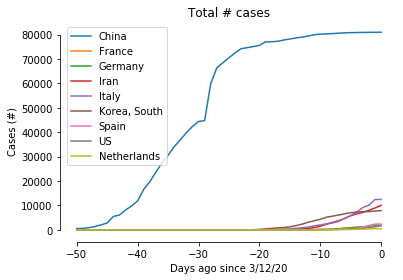

In [13]:
for country, color in zip(country_list, colors):
    plt.plot(df.loc[:,country], color=color, label=country)
plt.legend()
plt.title('Total # cases')
plt.xlabel('Days ago since {}'.format(last_date))
plt.ylabel('Cases (#)')
sns.despine(offset=2, trim=True)

The same, but now excluding China:

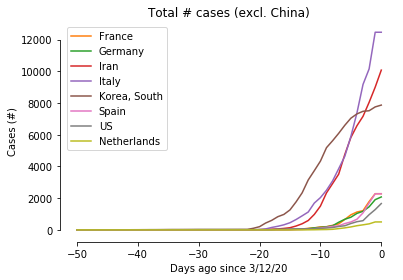

In [14]:
for country, color in zip(country_list, colors):
    if not country == 'China':
        plt.plot(df.loc[:,country], color=color, label=country)
        # plt.plot(df_c.loc[:,country].diff(), label=country)
plt.legend()
plt.title('Total # cases (excl. China)')
plt.xlabel('Days ago since {}'.format(last_date))
plt.ylabel('Cases (#)')
sns.despine(offset=2, trim=True)

Let's start with computing the world-wide mortality rate.  
-- Mortality rate based on the total number of cases = # deaths / # cases.  
-- Mortality rate based on the closed cases = # deaths / (# deaths + # recoveries).  
Let's compute these numbers:

In [15]:
mortality_total = df_d.iloc[-1].sum() / df.iloc[-1].sum() * 100
mortality_closed = df_d.iloc[-1].sum() / (df_c.iloc[-1].sum()) * 100
print('mortality rate total = {}%'.format(round(mortality_total, 3)))
print('mortality rate closed = {}%'.format(round(mortality_closed, 3)))

mortality rate total = 3.678%
mortality rate closed = 6.462%


The first measure is likely to be an underestimate, because lots of open cases can still end up in death.  
The second measure is an overestimate, because it’s likely that deaths are closed quicker than recoveries.  
Thus, the true mortality rate likely lies somewhere in between. In the case of China, where the epidemic is currently under control, it's nice to see that the two measures converge (see also https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca):

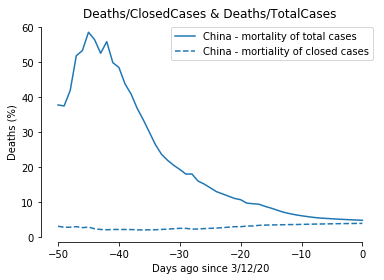

In [16]:
df_m_total = (df_d/df*100)
df_m_closed = (df_d/df_c*100)
for country, color in zip(country_list, colors):
    if (country == 'China'):
        plt.plot(df_m_closed.loc[:,country], color=color, label=country + ' - mortality of total cases')
        plt.plot(df_m_total.loc[:,country], ls='--', color=color, label=country + ' - mortiality of closed cases')
plt.legend()
plt.title('Deaths/ClosedCases & Deaths/TotalCases')
plt.xlabel('Days ago since {}'.format(last_date))
plt.ylabel('Deaths (%)')
sns.despine(offset=2, trim=True)

Let's assume the true mortality rate lies in the middle of the two computed measures:

In [17]:
mortality = (mortality_total + mortality_closed) / 2
print(mortality)

5.0697518331369


We can use this measure to predict the number of infections based on the number of reported cases, number of deaths and the number of recoveries. Specifically: 

# n deaths predict: n * (100 / mortality rate) infections

Remember that the number of deaths is made up of the actual number of deaths, plus the predicted number of deaths based on the open cases. Thus:

In [18]:
df_d_predicted = df_d + (df_o / (100 / mortality))
df_predicted = (df_d_predicted * (100 / mortality)) 
df_predicted.tail()

,Afghanistan,Albania,Algeria,Andorra,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahrain,...,Taiwan*,Thailand,Togo,Tunisia,Turkey,US,Ukraine,United Arab Emirates,United Kingdom,Vietnam
-4,4.0,0.000000,19.000000,1.0,30.724831,1.0,111.174494,104.000000,9.0,81.0,...,50.724831,37.724831,1.0,2.0,0.0,904.221459,1.0,38.0,312.174494,14.0
-3,4.0,2.000000,20.000000,1.0,30.724831,1.0,126.174494,129.000000,9.0,81.0,...,48.724831,37.724831,1.0,2.0,0.0,987.946290,1.0,38.0,378.899325,14.0
-2,5.0,10.000000,20.000000,1.0,35.724831,1.0,142.174494,178.000000,11.0,88.0,...,48.724831,38.724831,1.0,5.0,0.0,1475.295278,1.0,62.0,477.348988,15.0
-1,7.0,30.724831,20.000000,1.0,37.724831,1.0,163.174494,242.000000,8.0,160.0,...,49.724831,43.724831,1.0,7.0,1.0,1947.093929,1.0,57.0,589.798651,22.0
0,7.0,41.724831,34.724831,0.0,37.724831,4.0,163.174494,316.724831,8.0,160.0,...,47.724831,54.724831,1.0,7.0,1.0,2399.993255,1.0,68.0,589.798651,23.0


For China we can see that our predicted is not too far of:

In [19]:
print('predicted # cases China = {}'.format(int(df_predicted['China'].iloc[-1])))
print('reported # cases China = {}'.format(df['China'].iloc[-1]))

predicted # cases China = 77426
reported # cases China = 80932


In other words, in China, **most** of all the prediced COVID19 cases are reported and tracked.

Let's plot the fraction of unreported cases of the the predicted cases in China:

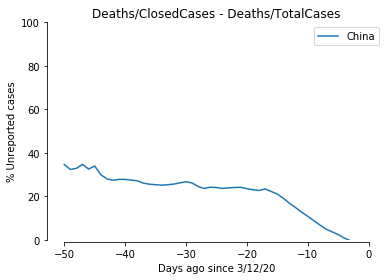

In [20]:
df_reported = 100 - (df / df_predicted * 100)
for country, color in zip(country_list, colors):
    if country == 'China':
        plt.plot(df_reported.loc[:,country], color=color, label=country)
plt.legend()
plt.title('Deaths/ClosedCases - Deaths/TotalCases')
plt.xlabel('Days ago since {}'.format(last_date))
plt.ylabel('% Unreported cases')
plt.ylim(0,100)
sns.despine(offset=2, trim=True)

Thus, for a long time it seems that >20% of cases went unreported. Reasons for this are: (i) infected people think they just have a bad cold, (ii) infected people are not ill at all because of 14 days incubation time, (iii) not enough testing kits, etc. Whatever the reason, unreported cases mean untracked cases, and thus an increases risk of community spread.  

**Why did these untracked cases not cause more harm in China? Simply because they were all contained within the Wuhan region, and thus could not spread beyond!**
  
In other regions something different is going on...

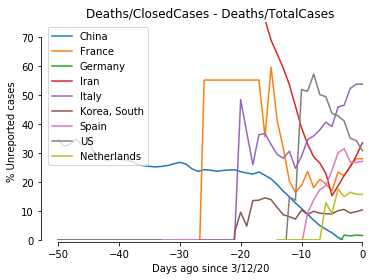

In [21]:
df_reported = 100 - (df / df_predicted * 100)
for country, color in zip(country_list, colors):
    plt.plot(df_reported.loc[:,country], color=color, label=country)
plt.legend()
plt.title('Deaths/ClosedCases - Deaths/TotalCases')
plt.xlabel('Days ago since {}'.format(last_date))
plt.ylabel('% Unreported cases')
plt.ylim(0,75)
sns.despine(offset=2, trim=True)

Here you see that in many European countries and the US more than >=25% of predicted COVID19 cases go unreported. In Italy and the US this was or is even around 50%! Italy is now on lockdown, which will probably contain the number of cases, just as it did in China. In the US, however, the virus can still go wherever it pleases. Note that the predicted fraction of unreported cases tends to be very high just *before* an exponential increase (compare this last figure, to the first two).